In [1]:
%matplotlib inline

from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

import seaborn as sns
sns.set(font_scale=1.75)
sns.set_style("ticks")

def load_scores(experiment):
    with open(os.path.join(experiment, "run.log")) as log_f:
        groups = {}
        group = {}
        step = 0
        for line in log_f:
            if " [step] " in line:
                groups[step] = group
                group = {}
                step = int(line.split()[-1])
            elif " [task] " in line:
                parts = line.split()
                task = parts[4]
                score = float(parts[6])
                assert task not in group
                group[task] = score
        groups[step] = group
        return groups
    
def plot_means(experiments, n_tasks):
    max_step = 3000000
    for experiment, style in experiments.items():
        label, color, ls = style
        steps = []
        means = []
        scores = load_scores(experiment)
        for step in sorted(scores.keys()):
            block = scores[step]
            mean = sum(block.values()) / n_tasks
            steps.append(step)
            means.append(mean)
        plt.plot(steps, means, label=label, color=color, ls=ls)
    plt.legend(loc=2)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlim([0, max_step])
    plt.ylim([0, 1])
    plt.show()
    
TASK_LENS = {
    "make[stick]": 2,
    "make[cloth]": 2,
    "make[rope]": 2,
    "make[plank]": 2,
    "make[bridge]": 3,
    "make[bed]": 4,
    "get[gold]": 4,
    "make[shears]": 4,
    "make[axe]": 4,
    "get[gem]": 5,
    'go[LL]': 2, 
    'go[URU]': 3, 
    'go[LLD]': 3, 
    'go[LD]': 2, 
    'go[UL]': 2, 
    'go[DRU]': 3, 
    'go[RD]': 2, 
    'go[LUR]': 3, 
    'go[RDD]': 3, 
    'go[UR]': 2
}
MAX_TASK_LEN = 5
    
def plot_hist(experiment, n_tasks):
    max_step = 3000000
    index = {}
    scores = load_scores(experiment)
    x = list(sorted(scores.keys()))
    y = [[0 for _x in range(len(x))] for _t in range(n_tasks)]
    for ix, _x  in enumerate(x):
        for k in scores[_x]:
            if k not in index:
                index[k] = len(index)
            i = index[k]
            y[i][ix] = scores[_x][k] / n_tasks
            
    labels = []
    colors = []
    for k, v in sorted(index.items(), key=lambda x: x[1]):
        labels.append(k)
        colors.append(np.ones(3) * TASK_LENS[k] / MAX_TASK_LEN * 0.9)
            
    plt.stackplot(x, y, labels=labels, colors=colors, edgecolor=(1, 1, 1))
            
    #plt.legend(loc=2)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlim([0, max_step])
    plt.ylim([0, 1])
    plt.show()

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


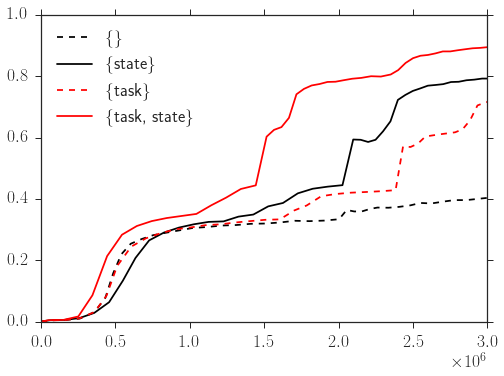

In [2]:
plot_means(
    {"craft_modular_common-nostate-baseline": ("\{\}", "k", "--"),
     "craft_modular_common-baseline": ("\{state\}", "k", "-"), 
     "craft_modular_task-baseline": ("\{task\}", "r", "--"),
     "craft_modular_state-baseline": ("\{task, state\}", "r", "-")},
    10)

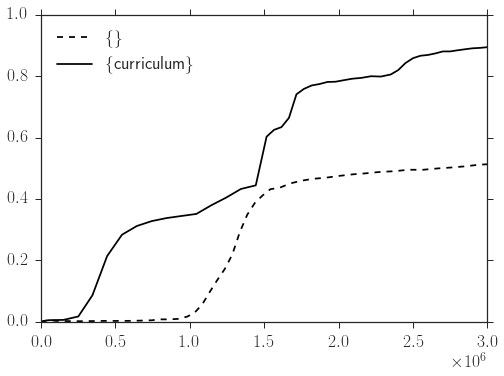

In [3]:
plot_means(
    {"craft_modular_no-curriculum": ("\{\}", "k", "--"),
     "craft_modular_state-baseline": ("\{curriculum\}", "k", "-")},
    10)

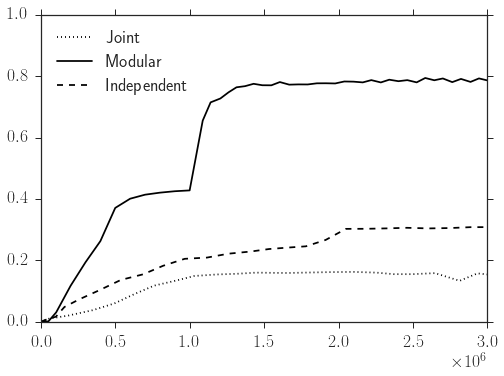

In [4]:
plot_means(
    {"light_indep": ("Independent", "k", "--"),
     "light_joint": ("Joint", "k", ":"),
     "light_modular": ("Modular", "k", "-")},
    10)

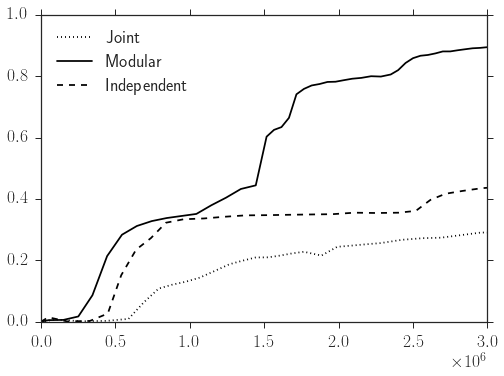

In [5]:
plot_means(
    {"craft_indep": ("Independent", "k", "--"),
     "craft_joint": ("Joint", "k", ":"),
     "craft_modular_state-baseline": ("Modular", "k", "-")},
    10)

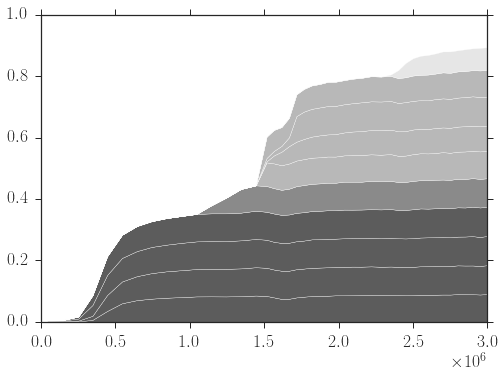

In [6]:
plot_hist("craft_modular_state-baseline", 10)

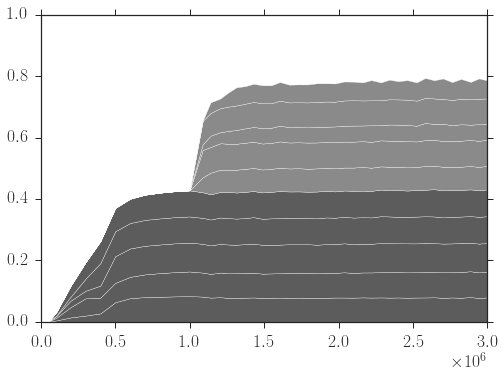

In [7]:
plot_hist("light_modular", 10)